## **Assignment 5 - Interim Results - Group 3**

This project focuses on developing a Convolutional Neural Network (CNN) model to classify microscopic blood smear images into two categories: LYT (Lymphocyte T-cells) and LYA (Lymphoblasts – abnormal cells associated with leukemia). The primary objective is to assist in the early detection of Acute Lymphoblastic Leukemia (ALL) by automating the differentiation between normal and leukemic cells.

The dataset consists of augmented LYA images (450) and LYT images (450), sourced from a real-world collection stored in Google Drive. To ensure reliable performance, we:

- Balanced the dataset to prevent class bias

- Performed basic EDA including metrics like mean intensity, standard deviation, PSNR, and SSIM

- Built a CNN model from scratch for binary classification

- Evaluated performance using accuracy, confusion matrix, and classification report

- Enabled both individual and batch-level predictions for clinical simulation

This pipeline was implemented and tested using Google Colab, making it reproducible, efficient, and well-suited for research and medical diagnostics contexts.

Dataset is taken from AML-CYTOMORPHOLOGY_LMU - The Cancer Imaging Archive (TCIA) https://www.cancerimagingarchive.net/collection/aml-cytomorphology_lmu/

Dataset and Results used in the notebook are available at https://drive.google.com/drive/folders/1WKQDFmim4F9zJfyCqJMzLzMJ6IHpytYQ?usp=sharing


### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Copy Images from Google Drive to Colab

In [2]:
import os

# Create folders in Colab's local storage
os.makedirs('/content/LYA', exist_ok=True)
os.makedirs('/content/LYT', exist_ok=True)

# Copy from Google Drive (replace with your actual paths!)
!cp "/content/drive/MyDrive/Case Studies/Data/LYA-Augmented/"* /content/LYA/
!cp "/content/drive/MyDrive/Case Studies/Data/LYT/"* /content/LYT/


### Optimize Image Loader Using PIL

In [3]:
from PIL import Image
import numpy as np

def load_images_pil(folder, label, size=(128, 128), limit=None):
    images, labels = [], []
    filenames = os.listdir(folder)

    for idx, filename in enumerate(filenames):
        if limit and idx >= limit:
            break
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('L').resize(size)
            images.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            continue
    return np.array(images), np.array(labels)


### Load & Balance Dataset

In [4]:
# Load balanced data from local Colab storage
lya_dir = '/content/LYA'
lyt_dir = '/content/LYT'

# Use the optimized PIL loader
lya_images, lya_labels = load_images_pil(lya_dir, label=1, limit=450)
lyt_images, lyt_labels = load_images_pil(lyt_dir, label=0, limit=450)

# Combine datasets
X = np.concatenate((lya_images, lyt_images), axis=0)
y = np.concatenate((lya_labels, lyt_labels), axis=0)

# Normalize & reshape
X = X / 255.0
X = X.reshape(-1, 128, 128, 1)

from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 2)


### Basic EDA with Mean, STD, PSNR, SSIM

In [5]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import pandas as pd

eda_data = []

for i in range(len(X)):
    img = X[i].reshape(128, 128)
    mean_val = np.mean(img)
    std_val = np.std(img)
    psnr_val = psnr(np.ones_like(img), img)
    ssim_val = ssim(np.ones_like(img), img, data_range=1.0)
    label = int(np.argmax(y[i]))
    eda_data.append([i, mean_val, std_val, psnr_val, ssim_val, label])

eda_df = pd.DataFrame(eda_data, columns=["Index", "Mean", "STD", "PSNR", "SSIM", "Label"])
eda_df.to_csv('/content/drive/MyDrive/Case Studies/Results/eda_results.csv', index=False)

### Plot EDA Results

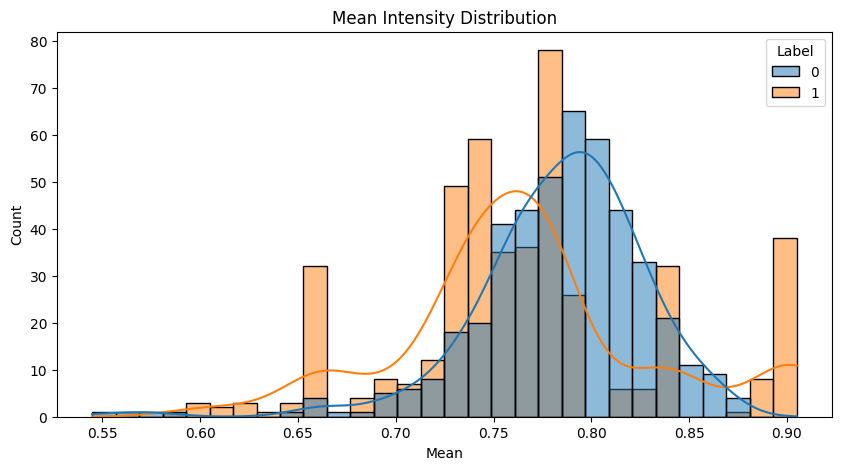

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mean distribution plot
plt.figure(figsize=(10,5))
sns.histplot(eda_df, x="Mean", hue="Label", kde=True, bins=30)
plt.title("Mean Intensity Distribution")
plt.savefig('/content/drive/MyDrive/Case Studies/Results/eda_mean_distribution.png')
plt.show()


### Mean Intensity Distribution – Insights

This plot shows the distribution of average grayscale intensities for two classes of images:

- **Label 0**: Normal lymphocytes (**LYT**)
- **Label 1**: Leukemic cells (**LYA**)



#### Observations:

- **Distinct Peaks:**
  - **LYT** images (blue) peak around **0.78–0.82**
  - **LYA** images (orange) peak around **0.74–0.76**
  - This suggests that **mean intensity is a useful discriminative feature**

- **Wider Spread in LYA:**
  - LYA images have a **broader and more varied distribution**, which aligns with biological variability in leukemic cells.

- **Overlap Exists:**
  - While there's overlap, the difference in peak regions implies that **intensity values still help the classifier learn meaningful patterns**.

- **Presence of Outliers:**
  - LYA has more extreme values (both low and high mean intensity), possibly due to **staining differences, morphological variance, or augmentation effects**.

#### Conclusion:
The intensity characteristics provide early evidence that **basic statistical image features** can help distinguish between healthy and leukemic cell types — even before deep learning is applied.


### Train/Val/Test Split (70:10:20)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, stratify=y_temp)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


Train: 630 Val: 90 Test: 180


### CNN Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,002 (28.20 MB)

 Trainable params: 7,392,002 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [9]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Save history as CSV
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('/content/drive/MyDrive/Case Studies/Results/training_history.csv', index=False)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.5667 - loss: 1.0181 - val_accuracy: 0.6667 - val_loss: 0.5835
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7351 - loss: 0.5360 - val_accuracy: 0.8111 - val_loss: 0.4365
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8458 - loss: 0.3696 - val_accuracy: 0.7444 - val_loss: 0.6192
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8751 - loss: 0.3391 - val_accuracy: 0.8778 - val_loss: 0.3351
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9109 - loss: 0.2167 - val_accuracy: 0.8111 - val_loss: 0.4380
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8648 - loss: 0.2940 - val_accuracy: 0.8667 - val_loss: 0.2964
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9381 - loss: 0.1718 - val_accuracy: 0.9333 - val_loss: 0.2421
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9396 - loss: 0.1654 - val_accuracy: 0.8667 -

### Plot Accuracy & Loss Curves

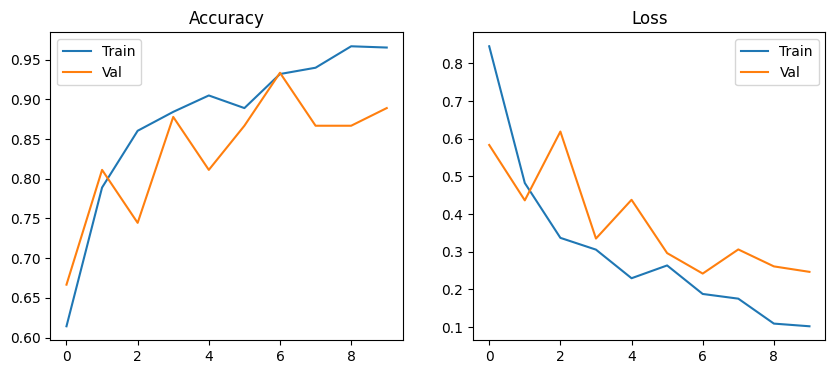

In [10]:
plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.savefig('/content/drive/MyDrive/Case Studies/Results/training_curves.png')
plt.show()


### Training vs Validation Accuracy and Loss – Insights

The plots above show the model's performance across 10 training epochs.



#### Accuracy Plot (Left):
- **Training accuracy** steadily improves from ~0.62 to **0.97**, indicating the model is learning effectively.
- **Validation accuracy** fluctuates early on, then stabilizes around **0.88–0.90**.
- The final gap between training and validation accuracy is small, suggesting **minimal overfitting**.


#### Loss Plot (Right):
- **Training loss** shows a consistent downward trend from **0.85 → 0.10**, indicating good convergence.
- **Validation loss** is slightly noisy, with small oscillations, but overall follows a decreasing trend.
- The validation loss stabilizes without diverging, supporting that the model is **generalizing well**.



#### Conclusion:
- The model demonstrates strong learning ability with **high training accuracy** and **stable validation performance**.
- No signs of severe overfitting or underfitting are present.
- To further improve generalization, future steps could include **data augmentation** or **early stopping**.


### Evaluate on Test Set + Confusion Matrix

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step


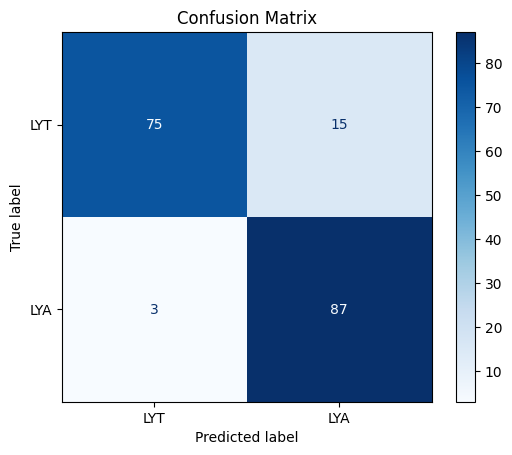

              precision    recall  f1-score   support

         LYT       0.96      0.83      0.89        90
         LYA       0.85      0.97      0.91        90

    accuracy                           0.90       180
   macro avg       0.91      0.90      0.90       180
weighted avg       0.91      0.90      0.90       180



In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["LYT", "LYA"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig('/content/drive/MyDrive/Case Studies/Results/confusion_matrix.png')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=["LYT", "LYA"])
print(report)

# Save classification report
with open('/content/drive/MyDrive/Case Studies/Results/classification_report.txt', 'w') as f:
    f.write(report)


### Confusion Matrix & Classification Report

The confusion matrix and classification report below summarize the model's performance on the test set (180 images: 90 LYT, 90 LYA).



#### Confusion Matrix:

|               | Predicted LYT | Predicted LYA |
|---------------|----------------|----------------|
| **True LYT**  | 75 (✔️ correct) | 15 (❌ false negative) |
| **True LYA**  | 3 (❌ false positive) | 87 (✔️ correct) |

- The model **correctly identified 87 out of 90 LYA** images (high recall for LYA).
- **Only 3 LYA samples** were misclassified as LYT.
- **15 LYT images** were misclassified as LYA, indicating slightly lower recall for LYT.



#### Classification Report:

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| **LYT** | 0.96 | 0.83 | 0.89 | 90 |
| **LYA** | 0.85 | 0.97 | 0.91 | 90 |
| **Accuracy** |  |  | **0.90** | 180 |
| **Macro Avg** | 0.91 | 0.90 | 0.90 | 180 |
| **Weighted Avg** | 0.91 | 0.90 | 0.90 | 180 |



#### Key Insights:

- **High Overall Accuracy:** 90% across both classes.
- **LYA Recall = 0.97** → Excellent at detecting leukemic cells.
- **LYT Recall = 0.83** → Some healthy cells misclassified as leukemic.
- **Precision trade-off:** The model is more cautious and favors detecting LYA (minimizing false negatives), which is **clinically preferable** in leukemia screening.



#### Conclusion:
The model is **highly effective at detecting leukemic cells (LYA)**, with a strong recall of 97%. Although it sometimes overpredicts LYA (leading to lower LYT recall), this bias toward sensitivity is acceptable and even desirable in early cancer detection scenarios.


### Prepare Your Test Image

In [12]:
from PIL import Image
import numpy as np

def preprocess_image(image_path, size=(128, 128)):
    img = Image.open(image_path).convert('L').resize(size)
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 128, 128, 1)
    return img_array


### Predict Using the Trained Model

In [13]:
# Path to a new image
test_path = '/content/drive/MyDrive/Case Studies/Data/LYT test/LYT_0001.tiff'

# Preprocess
test_img = preprocess_image(test_path)

# Predict
prediction = model.predict(test_img)
pred_class = np.argmax(prediction)

# Decode label
label_map = {0: 'LYT', 1: 'LYA'}
print("Predicted class:", label_map[pred_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
Predicted class: LYT


### Batch Predict from Folder

In [14]:
def predict_folder(folder_path):
    results = []
    for fname in os.listdir(folder_path):
        try:
            fpath = os.path.join(folder_path, fname)
            img = preprocess_image(fpath)
            pred = model.predict(img)
            label = np.argmax(pred)
            label_name = label_map[label]
            results.append([fname, label_name, float(pred[0][label])])
        except Exception as e:
            print(f"Skipping {fname}: {e}")
    return results

# Example: Predict all images in /content/drive/MyDrive/TestSamples
predictions = predict_folder('/content/drive/MyDrive/Case Studies/Data/LYT test')

# Save as CSV
pred_df = pd.DataFrame(predictions, columns=["Image", "Predicted_Label", "Confidence"])
pred_df.to_csv('/content/drive/MyDrive/Case Studies/Results/predictions.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


### Display Image with Prediction

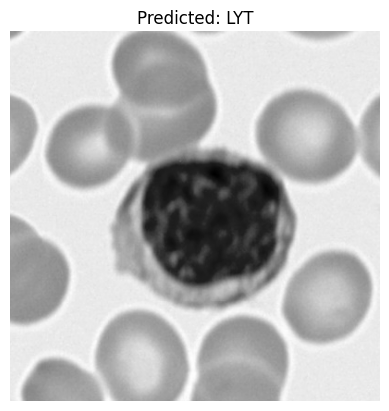

In [15]:
import matplotlib.pyplot as plt

img = Image.open(test_path).convert('L')
plt.imshow(img, cmap='gray')
plt.title(f"Predicted: {label_map[pred_class]}")
plt.axis('off')
plt.show()


### Batch Predict + Display Images with Predictions

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

label_map = {0: 'LYT', 1: 'LYA'}

def preprocess_image(image_path, size=(128, 128)):
    img = Image.open(image_path).convert('L').resize(size)
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 128, 128, 1)
    return img_array, img

def predict_and_display_folder(folder_path, show_images=True, save_csv=True):
    results = []

    for fname in os.listdir(folder_path):
        try:
            fpath = os.path.join(folder_path, fname)
            img_array, img_display = preprocess_image(fpath)

            pred = model.predict(img_array)
            pred_class = np.argmax(pred)
            confidence = float(pred[0][pred_class])
            label_name = label_map[pred_class]

            # Add to results
            results.append([fname, label_name, confidence])

            # Show image + prediction
            if show_images:
                plt.imshow(img_display, cmap='gray')
                plt.title(f"Predicted: {label_name} ({confidence:.2f})")
                plt.axis('off')
                plt.show()

        except Exception as e:
            print(f"Skipping {fname}: {e}")

    # Save to CSV
    if save_csv:
        pred_df = pd.DataFrame(results, columns=["Image", "Predicted_Label", "Confidence"])
        pred_df.to_csv('/content/drive/MyDrive/Case Studies/Results/predictions.csv', index=False)
        print("Saved predictions to Google Drive.")

    return results


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


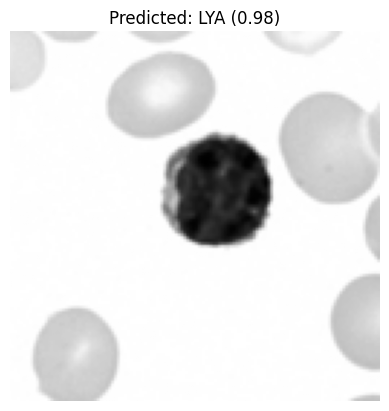

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


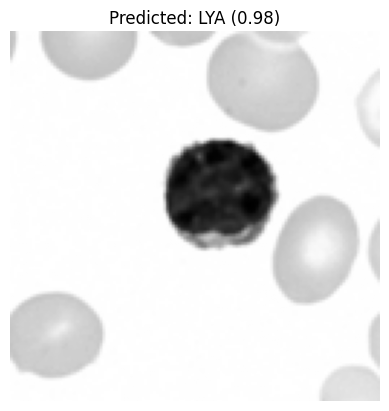

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


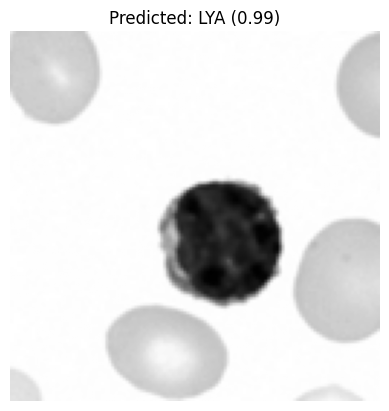

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


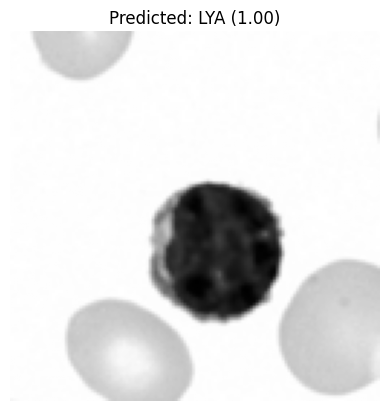

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


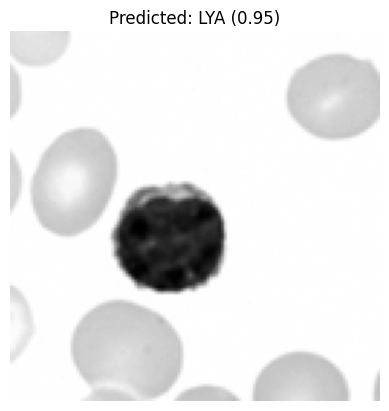

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


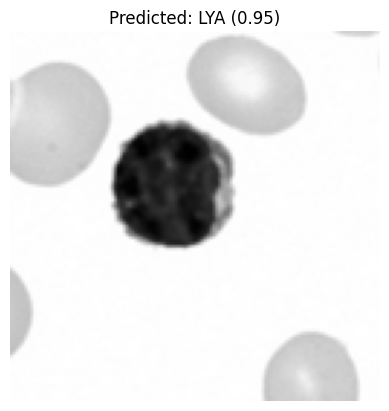

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


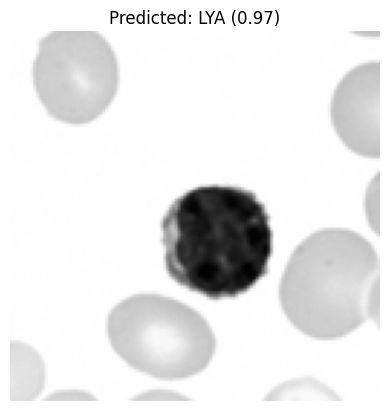

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


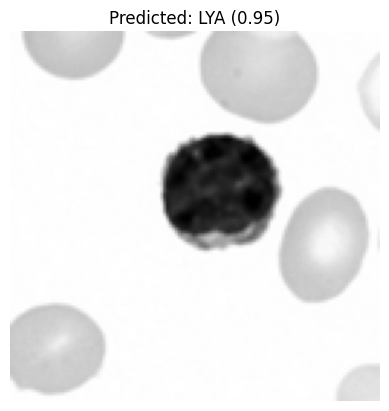

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


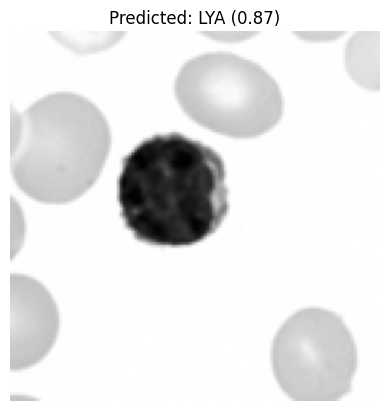

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


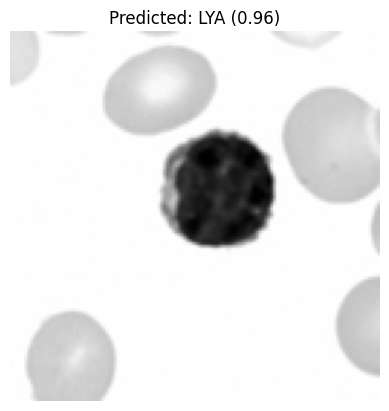

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


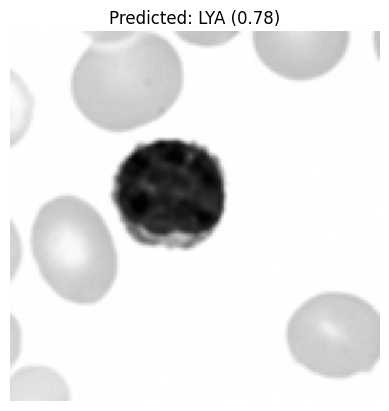

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


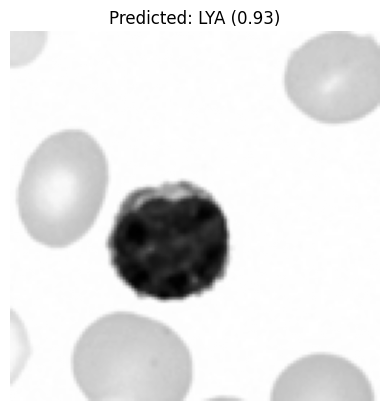

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


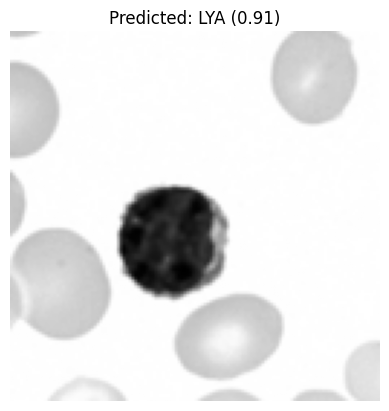

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


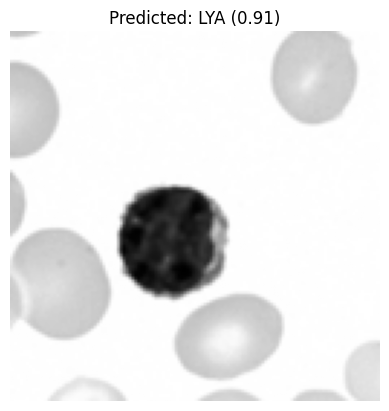

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


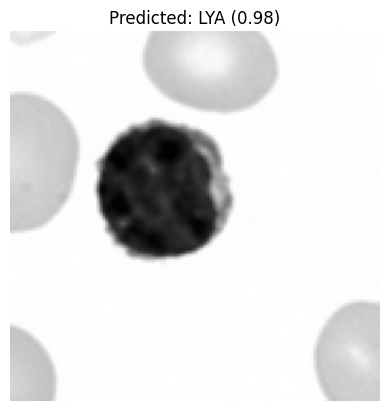

Saved predictions to Google Drive.


In [17]:
# Replace with your folder of test images
test_folder = '/content/drive/MyDrive/Case Studies/Data/LYA test'

# Run batch prediction + image display
predictions = predict_and_display_folder(test_folder)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


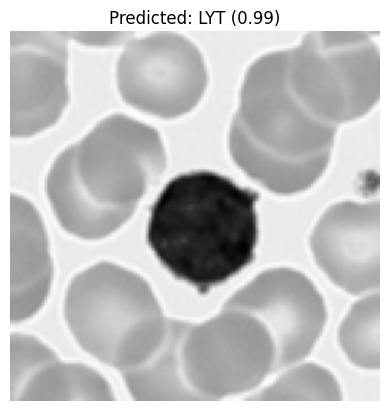

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


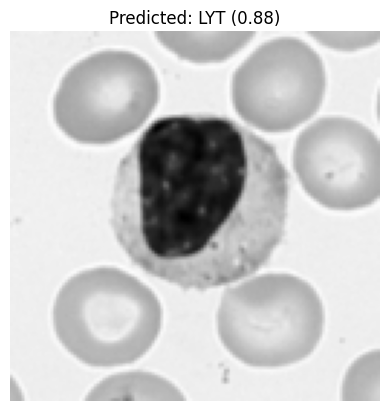

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


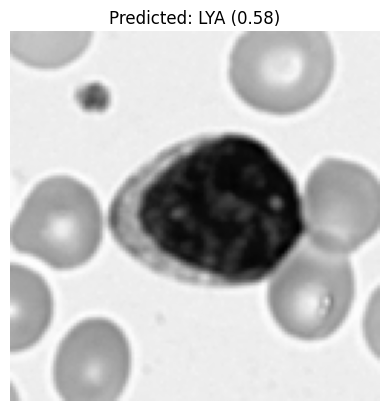

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


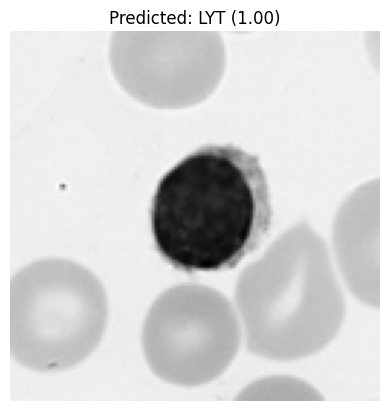

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


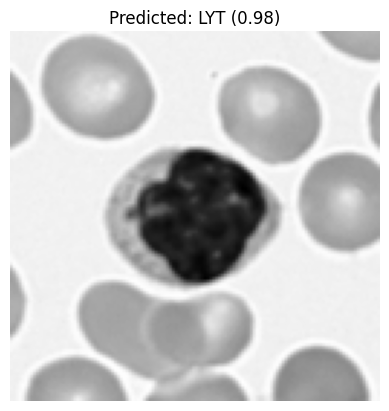

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


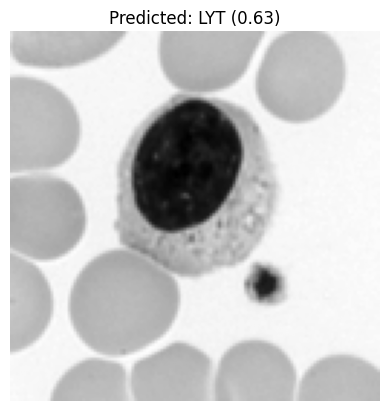

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


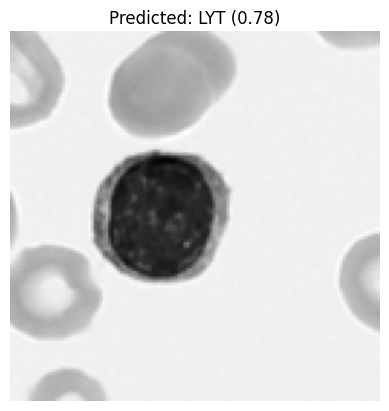

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


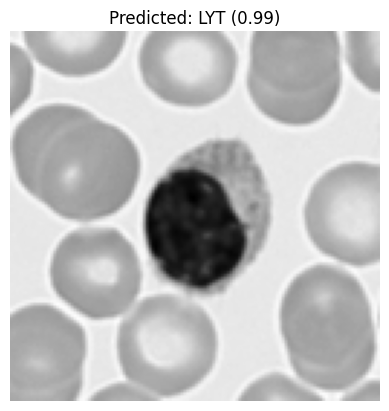

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


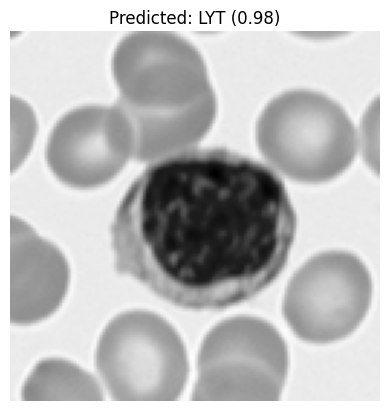

Saved predictions to Google Drive.


In [18]:
# Replace with your folder of test images
test_folder = '/content/drive/MyDrive/Case Studies/Data/LYT test'

# Run batch prediction + image display
predictions = predict_and_display_folder(test_folder)